<a href="https://colab.research.google.com/github/Jeff-004/Projects/blob/main/Time_Series_Forecasting_of_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA

In [60]:
# Load the data
df = pd.read_csv("/content/drive/MyDrive/Datasets/NFLX.csv", index_col='Date')
df.index = pd.to_datetime(df.index)

# Resample to weekly frequency and compute log returns
df_week = df.resample('W').mean()
df_week = df_week[['Close']]
df_week['weekly_ret'] = np.log(df_week['Close']).diff()
df_week = df_week[df_week['weekly_ret'].notnull()]

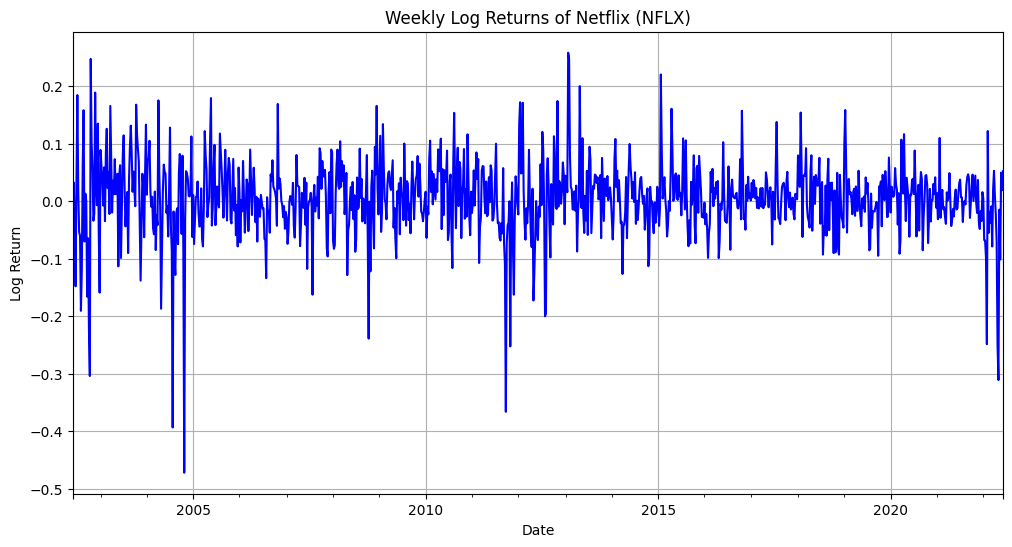

In [61]:
df_week['weekly_ret'].plot(kind='line', figsize=(12, 6), color='blue')
plt.title("Weekly Log Returns of Netflix (NFLX)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.show()

In [62]:
udiff = df_week[['weekly_ret']]  # Keep as DataFrame for compatibility

rolmean = udiff.rolling(20).mean()
rolstd = udiff.rolling(20).std()

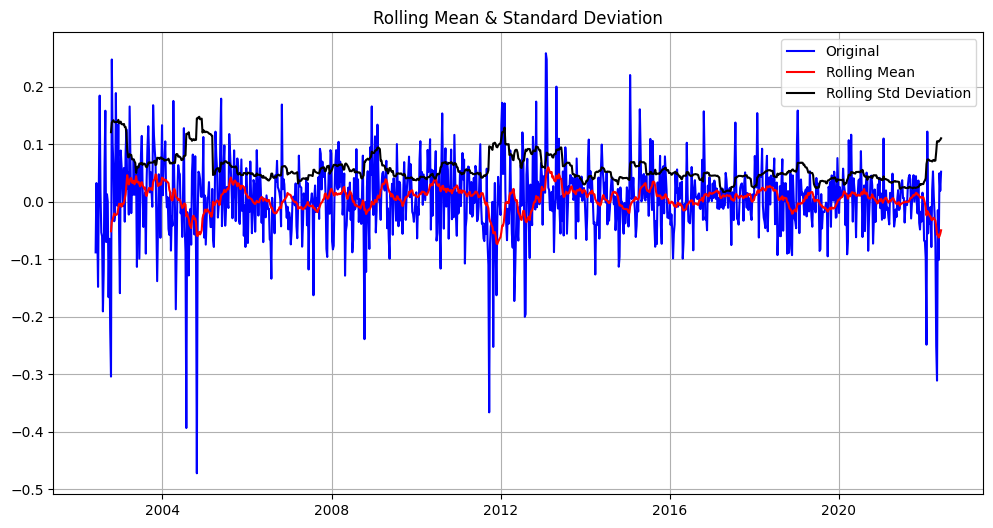

In [63]:
plt.figure(figsize=(12, 6))
plt.plot(udiff, color='blue', label='Original')
plt.plot(rolmean, color='red', label='Rolling Mean')
plt.plot(rolstd, color='black', label='Rolling Std Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [64]:
# Dickey-Fuller test
dftest = adfuller(udiff['weekly_ret'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput[f'Critical Value ({key})'] = value
print(dfoutput)

Test Statistic                -1.675527e+01
p-value                        1.323754e-29
#Lags Used                     2.000000e+00
Number of Observations Used    1.042000e+03
Critical Value (1%)           -3.436641e+00
Critical Value (5%)           -2.864318e+00
Critical Value (10%)          -2.568249e+00
dtype: float64


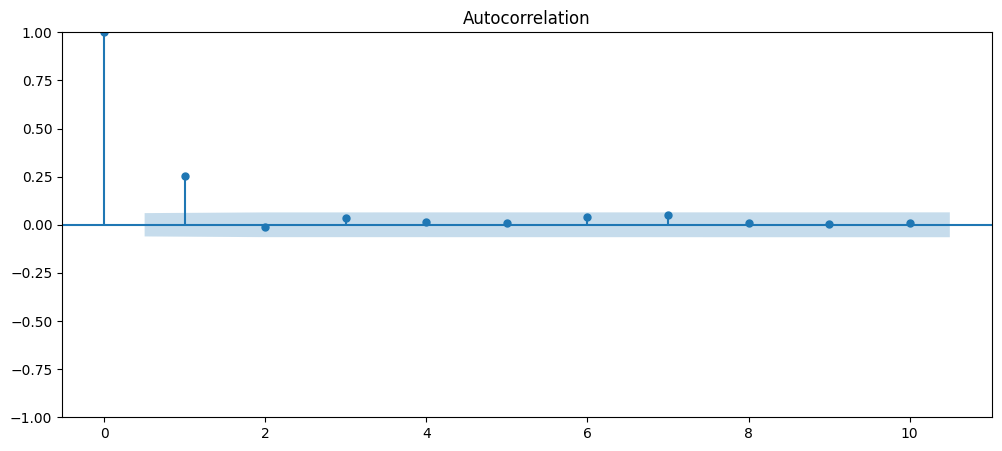

In [65]:
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(udiff['weekly_ret'], lags=10, ax=ax)
plt.show()

In [66]:
# Fit ARIMA directly to the pandas Series to preserve the index
arima_model = ARIMA(udiff['weekly_ret'], order=(3, 0, 3))
arima_fit = arima_model.fit()
print(arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             weekly_ret   No. Observations:                 1045
Model:                 ARIMA(3, 0, 3)   Log Likelihood                1402.843
Date:                Thu, 19 Jun 2025   AIC                          -2789.686
Time:                        14:52:02   BIC                          -2750.072
Sample:                    06-02-2002   HQIC                         -2774.662
                         - 06-05-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.003      1.583      0.113      -0.001       0.011
ar.L1          1.0785      1.095      0.985      0.325      -1.068       3.225
ar.L2         -0.2709      0.752     -0.360      0.7

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


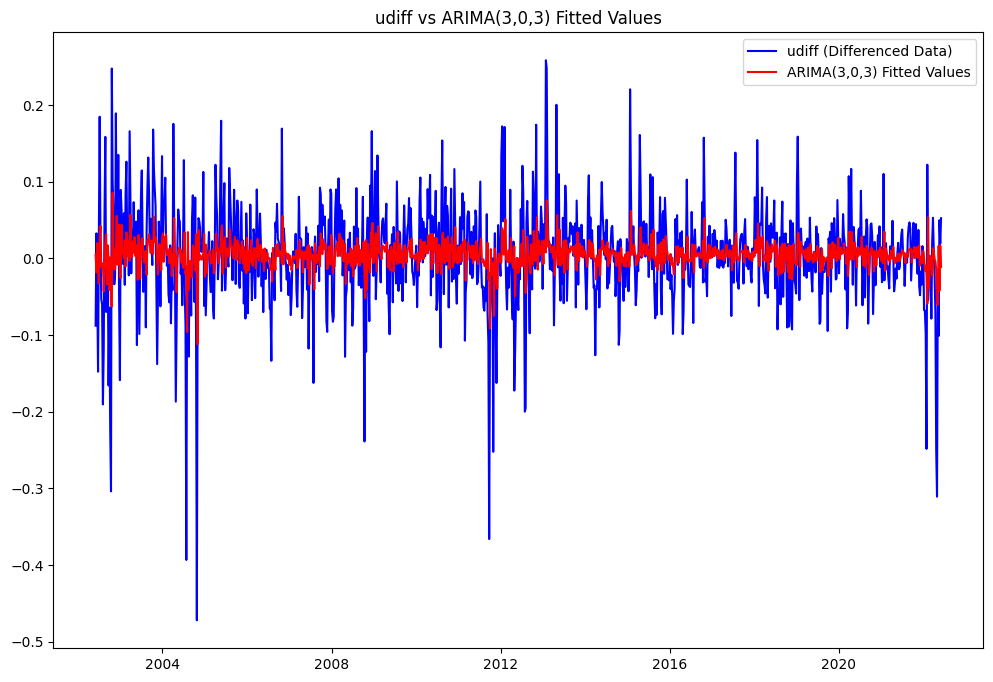

In [67]:
plt.figure(figsize=(12, 8))
plt.plot(udiff['weekly_ret'], color='blue', label='udiff (Differenced Data)')
plt.plot(arima_fit.fittedvalues, color='red', label='ARIMA(3,0,3) Fitted Values')
plt.legend()
plt.title('udiff vs ARIMA(3,0,3) Fitted Values')
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


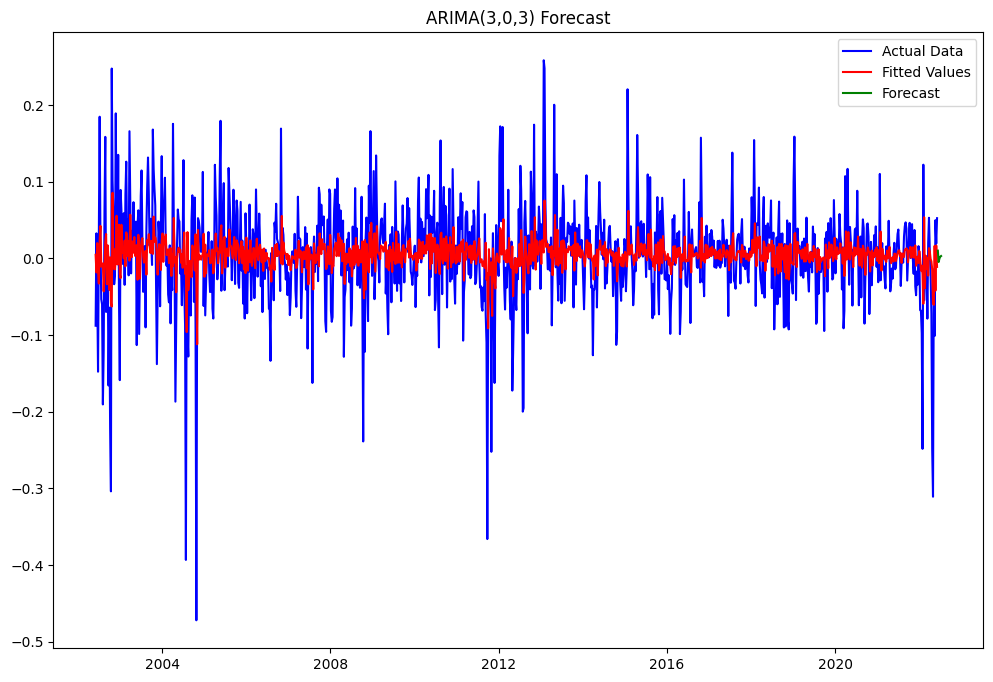

In [68]:
# Fit the ARIMA model correctly (with pandas Series)
ar1 = ARIMA(udiff['weekly_ret'], order=(3, 0, 3))  # Use the Series, not .values
ar1_fit = ar1.fit()

# Forecast future values
steps = 5
forecast = ar1_fit.get_forecast(steps=steps)  # Use get_forecast() for confidence intervals

# Generate future dates aligned with the original index
last_date = udiff.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=steps, freq='W')

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(udiff.index, udiff['weekly_ret'], color='blue', label='Actual Data')
plt.plot(ar1_fit.fittedvalues.index, ar1_fit.fittedvalues, color='red', label='Fitted Values')
plt.plot(future_dates, forecast.predicted_mean, color='green', label='Forecast')

plt.title('ARIMA(3,0,3) Forecast')
plt.legend()
plt.show()